In [26]:
import tensorflow as tf
import base64
import matplotlib.pyplot as plt

print("TF Version: {}".format(tf.__version__))

TF Version: 1.15.0


# Data Preparation

Here you are going to use the MNIST dataset as an example to generate tfrecord files.

In [0]:
from tensorflow.examples.tutorials.mnist import input_data

In [28]:
mnist = input_data.read_data_sets("/tmp/MNIST_data/", one_hot=True)

Extracting /tmp/MNIST_data/train-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/t10k-labels-idx1-ubyte.gz


In [29]:
mnist.train.images.shape, mnist.train.labels.shape

((55000, 784), (55000, 10))

# Write out tfrecord files

The `tfrecord` file is a highly compressed format that is mainly composed of `tf.train.Feature()`. You first need to define the transformation function from different data types to `tf.train.Feature`. 

The following are three different examples of three datatypes.


In [0]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

After you define the way to transform each data type, you next need to define a data schema describing the compose of a single piece of data (like a single data row). The following is an example of a data chunk composed of two attributes, that are images, and labels.

In [0]:
def create_tf_example(imgInByte, labelInByte):
  tf_example = tf.train.Example(features=tf.train.Features(feature={\
    'image': _bytes_feature(imgInByte) \
  , 'label': _bytes_feature(labelInByte) \
  }))
  return tf_example

The following is an example to manipulate the image data. First, transform the data into the binary format and then encode the data into base64 format. These transformations are common while transmitting images over the network.

 A function `Base64Converter` helps you to encode the binary data in base64 format and also introduce a safe way to do the encoding, called safe base64. Unlike the origin base64 encoding, the safe way tries to replace the '+' with '-' and replace the '/' with '_'.

In [0]:
def Base64Converter(byte_string):
  _byteStr = base64.b64encode(byte_string)
  return _byteStr[:-2].replace(b"+", b"-").replace(b"/", b"_")

Now you can generate a `tfrecord` file by sequential compressing each piece of data.

In [0]:
with tf.python_io.TFRecordWriter("./mnist_test.tfrecord") as writer:
  for i in range(mnist.test.num_examples):
    writer.write(
      create_tf_example(
        Base64Converter(mnist.test.images[i].astype("float32").tobytes()),  # [None, 784]
        Base64Converter(mnist.test.labels[i].astype("float32").tobytes())   # [None, 10]
      ).SerializeToString()
    )

# Read the tfrecord files

The following function is an example showing how to decode the each piece of data and to transform it into the correct datatype.

In [0]:
def read_and_decode(filename_queue):
  # create a tfrecord object
  reader = tf.TFRecordReader()
  _, serialized_example = reader.read(filename_queue)
  
  # decode the example
  features = tf.parse_single_example(
      serialized_example,
      features={'image':tf.FixedLenFeature([], tf.string), 
                'label':tf.FixedLenFeature([], tf.string)})
  
  label = tf.io.decode_base64(features["label"])
  label = tf.io.decode_raw(label, tf.float32)
  
  # it must decode byteslist from string type to uint8 type
  image = tf.io.decode_base64(features["image"])
  image = tf.io.decode_raw(image, tf.float32)
  return image, label

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


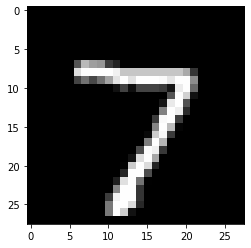

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


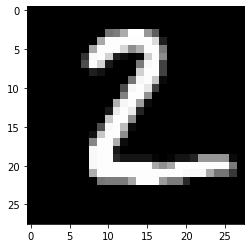

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


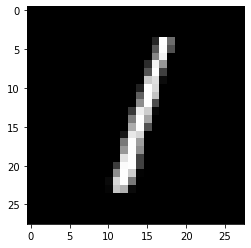

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Enqueue operation was cancelled
	 [[{{node input/input_producer/input_producer_EnqueueMany}}]]


In [35]:
tf.reset_default_graph()

with tf.name_scope('input'):
  # return a QueueRunner object and FIFOQueue object inside in
  filename_queue = tf.train.string_input_producer(
      ["./mnist_test.tfrecord"], num_epochs=None)
  
  image, label = read_and_decode(filename_queue)
  
  with tf.Session() as sess:

    # because one epoch variable is built inside string_input_produer (image_raw)
    # and the variable is belonging to tf.GraphKeys.LOCAL_VARIABLES
    # tf.local_variables_initializer() is necessary
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)

    coord=tf.train.Coordinator()
    threads= tf.train.start_queue_runners(coord=coord)
    
    for i in range(0, 3, 1):
      img, lbl = sess.run([image, label])
      print(lbl)
      img = img.reshape(28, 28)
      plt.imshow(img, cmap=plt.cm.gray)
      plt.show()